In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
import pandas as pd
from xbbg import blp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta as td
import statsmodels.api as sm
import re
import matplotlib.image as image
from ipywidgets import interact, IntSlider, Checkbox, Dropdown, Output, HBox, VBox, interactive, interactive_output, ToggleButton,Text, Button, DatePicker, IntText, ToggleButtons, RadioButtons,SelectMultiple
from IPython.display import display, clear_output
import itertools
from scipy import stats
from scipy.optimize import minimize 
from scipy.special import ndtr

spot_library = {'eur_6':['EUSA', ' Curncy'],'eur': ['EESWE', ' Curncy'], 'usd': ['USOSFR', ' Curncy'], 
                'gbp': ['BPSWS', ' Curncy'],'chf': ['SFSNT', ' Curncy'],'sek': ['SKSW', ' Curncy'],
                 'nok': ['NKSW', ' Curncy'], 'hkd': ['HDSW', ' Curncy'],'czk': ['CKSW', ' Curncy'],
                 'pln': ['PZSW', ' Curncy'],'ils':['ISSW', ' Curncy'],  'cad':['CDSW', ' Curncy'], 
                 'jpy':['JYSO', ' Curncy'], 'aud': ['ADSW', ' Curncy'],'sgd':['SDSW', ' Curncy'],
                'krw': ['KWSWNI', ' Curncy'],
                'zar': ['SASW', ' Curncy'],
                'nzd': ['NDSW', ' Curncy'],
                'mxn': ['MPSW', ' Curncy']} 

forward_library = {'eur_6': ['EUSA', ' Curncy'], 
                 'eur': ['S0514FS ', ' BLC Curncy'], 
                 'usd': ['S0490FS ', ' BLC Curncy'], 
                 'gbp': ['S0141FS ', ' BLC Curncy'],
                 'chf': ['S0234FS ', ' BLC Curncy'],
                 'sek': ['SD0020FS ', ' BLC Curncy'],
                 'nok': ['SD0313FS ', ' BLC Curncy'],
                 'hkd': ['HDFS', ' Curncy'],
                 'czk': ['S0320FS ', ' BLC Curncy'],
                 'pln': ['S0323FS ', ' BLC Curncy'],
                 'ils': ['ISFS', ' Curncy'],
                 'cad': ['CDFS', ' Curncy'],
                 'jpy': ['S0195FS ', ' BLC Curncy'],
                 'aud': ['SD0302FS ', ' BLC Curncy'],
                'sgd': ['SDFS', ' Curncy'],
                'krw': ['S0205FS ', ' BLC Curncy'],
                'zar': ['SAFS', ' Curncy'],#
                'nzd': ['SD0015FS ', ' BLC Curncy'],
                'mxn': ['SD0083FS ', ' BLC Curncy']} 

################################################# SWAP STRUCTURE BUILDERS ################################################

def cut(some):
    x = 0
    y = some[0]
    while y.isdigit():
        y=some[x]
        x+=1
    return some[:x],some[x:]


def f(tenor):
    x = re.findall(r'\d+',tenor)[0]
    num = ''
    if 'm' in tenor.lower():
        if int(x) // 12 >0:
            num+='1'
        num+=chr(64+(int(x)%12))
    else:
        if len(x) == 1:
            num+='0'
        num +=x
    return num

def t(tenor):
    x = re.findall(r'\d+',tenor)[0]
    num = ''
    if 'm' in tenor.lower():
        if int(x) // 12 >0:
            num+='1'
        else:
            num+='0'
        num+=chr(64+(int(x)%12))
    else:
        if len(x) == 1:
            num+='0'
        num +=x
    return num


def spot_ticker(dex,tenor):
    if dex.lower() == 'mxn':
        y = int(tenor[:-1]) * 13
        num = f'{y//12}{chr(64+(y%12))}'
    else:
        num = tenor[:-1]
    return f'{spot_library[dex][0]}{num}{spot_library[dex][1]}'

def forward_ticker(dex,fwd):
    dex = dex.lower()
    fwd = fwd.lower()
    old = ['eur_6','hkd','ils','cad','sgd','zar']
    
    if cut(fwd)[0] == '0y':
        return spot_ticker(dex,cut(fwd)[1])
    elif dex == 'eur_6':
        F,T = f(cut(fwd)[0]),t(cut(fwd)[1])
        return f'{forward_library[dex][0]}{F}{T}{forward_library[dex][1]}'
    elif dex in old:
        F,T = t(cut(fwd)[0]),t(cut(fwd)[1])
        return f'{forward_library[dex][0]}{F}{T}{forward_library[dex][1]}'
    else:
        
        return f'{forward_library[dex][0]}{fwd.upper()}{forward_library[dex][1]}'


def swap_structure(dex,structure,start, end = 'today',bps = True):
    f_fly = structure.count('/') == 2
    f_crv = structure.count('/') == 1  
    fly = structure.count('s') == 3
    crv = structure.count('s') == 2
    out = max(2 -sum([i.isalpha() for i in structure]),0)
    
    if f_fly or f_crv:
        legs = [forward_ticker(dex,i) for i in structure.split('/')]
    elif fly or crv:
        legs = [spot_ticker(dex,i) for i in [i+'Y' for i in structure.split('s') if i.isdigit()]]
    else:
        legs = forward_ticker(dex,('0Y'*out) + structure)
        
    df = blp.bdh(legs, flds='px_last', start_date=start,end_date=end).fillna(method ='bfill')  *(100 if bps else 1)
    s  = pd.DataFrame({})
    if f_fly or fly:
        x = (2 * df.iloc[:,1]) - (df.iloc[:,0] + df.iloc[:,2])
    elif f_crv or crv:
        x = df.iloc[:,1] - df.iloc[:,0]
    else:
        x = df.iloc[:,0]
        
    s[f'{dex.upper()} {structure}'] = x
    return s

################################################# BOND STRUCTURE BUILDERS ################################################
def bond_ticker(bond_name, bond_tenor):
    cmb = {'ust':1,'dbr':2,'spgb':8,'frtr':4,'btp':5,'ukt':6}
    return f'RV000{cmb[bond_name]}P {bond_tenor.upper()} BLC Curncy'

def bond_structure(bonds,structure, start, end = 'today'):
    if '-' in bonds:
        s = pd.DataFrame({})
        bond1,bond2 = bonds.split('-')
        s[f'{bonds.upper()} {structure}'] = bond_structure(bond1,structure, start, end)[f'{bond1.upper()} {structure}'] - bond_structure(bond2,structure, start, end)[f'{bond2.upper()} {structure}']
        return s
    else:
        if 'y' in structure.lower(): #bond o/r
            tickers = bond_ticker(bonds.lower(), structure)
            base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
            base.columns = [f'{bonds.upper()} {structure}']
            return base
        
        elif structure.lower().count('s') == 2: #bond curve
            tickers = [bond_ticker(bonds.lower(), f'{i}y') for i in structure.lower().split('s') if i != '']
            base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
            base.columns = tickers
            s = pd.DataFrame({})
            s[f'{bonds.upper()} {structure}'] = base[tickers[1]] - base[tickers[0]]
            return s
        
        elif structure.lower().count('s') == 3: # bond fly
            tickers = [bond_ticker(bonds.lower(), f'{i}y') for i in structure.lower().split('s') if i != '']
            base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
            base.columns = tickers
            s = pd.DataFrame({})
            s[f'{bonds.upper()} {structure}'] = (2*base[tickers[1]]) - (base[tickers[0]] + base[tickers[2]])
            return s

################################################# FUTURES STRUCTURE BUILDERS ################################################

def fut_ticker(dex, contract, name = False):
    x  = ''
    if dex.lower()[:3] == 'eur':
        x = 'ER'
    elif dex.lower() == 'usd':
        x = 'SFR'
    elif dex.lower() == 'gbp':
        x = 'SFI'
    
    if name:
        return x
    else:
        return f'{x}{contract} Comdty'   
           
    
def fut_structure(dex,structure, start, end = 'today'):
    name = fut_ticker(dex.lower(), 0,True)
    
    if structure.lower().count('s') == 2: #fut curve
        tickers = [fut_ticker(dex.lower(), int(i)) for i in structure.lower().split('s') if i != '']
        base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
        base.columns = tickers
        s = pd.DataFrame({})
        s[f'{name}{structure.replace("s","")}'] = base[tickers[0]] - base[tickers[1]]
        return s
        
    elif structure.lower().count('s') == 3: # fut fly
        tickers = [fut_ticker(dex.lower(), int(i)) for i in structure.lower().split('s') if i != '']
        base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
        base.columns = tickers
        s = pd.DataFrame({})
        s[f'{name}{structure.replace("s","")}'] = (2*base[tickers[1]]) - (base[tickers[0]] + base[tickers[2]])
        return s
    else:
        tickers = fut_ticker(dex.lower(), structure)
        base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
        base.columns = [f'{name}{structure}']
        return base

################################################# ASW STRUCTURE BUILDERS ################################################

def get_asw(bond_name,tenor,start, end ='today',euro = 'estr'):
    asso_swap = {'ust':'usd','dbr':'eur','spgb':'eur','frtr':'eur','btp':'eur','ukt':'gbp'}
    
    if asso_swap[bond_name] == 'eur' and euro != 'estr':
        tickers = [bond_ticker(bond_name,tenor), spot_ticker(asso_swap[bond_name]+'_6',tenor)]
    else:
        tickers = [bond_ticker(bond_name,tenor), spot_ticker(asso_swap[bond_name],tenor)]
    base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
    base.columns = tickers
    s = pd.DataFrame({})
    s[f'{tenor.upper()} {bond_name.upper()} ASW'] = base[tickers[1]] - base[tickers[0]]
    return s

def asw_structure(bonds,structure, start, end = 'today',euro = 'estr'):
    if '-' in bonds:
        s = pd.DataFrame({})
        bond1,bond2 = bonds.split('-')
        s[f'{bonds.upper()} ASW {structure}'] = asw_structure(bond1,structure, start, end,euro)[f'{bond1.upper()} ASW {structure}'] - asw_structure(bond2,structure, start, end,euro)[f'{bond2.upper()} ASW {structure}']
        return s
    else:
        if 'y' in structure.lower(): #asw o/r
            return get_asw(bonds,structure,start, end,euro)
        
        elif structure.lower().count('s') == 2: #asw curve
            legs = [ f'{i}y' for i in structure.lower().split('s') if i != '']
            short_leg, long_leg = [get_asw(bonds,i,start,end,euro) for i in legs]
            df = short_leg.join(long_leg, how = 'inner')
            s = pd.DataFrame({})
            s[f'{bonds.upper()} ASW {structure}'] = df.iloc[:,1]  - df.iloc[:,0]  
            return s
        
        elif structure.lower().count('s') == 3: # asw fly
            legs = [ f'{i}y' for i in structure.lower().split('s') if i != '']
            short_leg, belly ,long_leg = [get_asw(bonds,i,start,end,euro) for i in legs]
            short_leg = short_leg.join(belly, how = 'inner')
            df = short_leg.join(long_leg, how = 'inner')
            s = pd.DataFrame({})
            s[f'{bonds.upper()} ASW {structure}'] = (2 * df.iloc[:,1])  - (df.iloc[:,0] + df.iloc[:,2])  
            return s
        

######################################### TICKER HANDLERS #################################################################

def get_other(ticker,attribute,title,start,end='today' ):
    if 'price' in attribute.lower():
        attribute = 'px_last'
    else:
        attribute = 'YLD_YTM_MID'
    base = blp.bdh(ticker,attribute,start,end)
    base.columns = [title]
    return base

######################################### INVOICE SPREAD STRUCTURE BUILDERS ################################################


def get_ivsp(country,start, end ='today',which = 'TUA',euro ='estr'):
    tkr = {'USD':['TUAISPS','3YAISPS','FVAISPS','TYAISPS','UXYAISPS','USAISPS','WNAISPS'],
           'GER':['DUAISP','OEAISP','RXAISP','UBAISP'],
           'ITA':['BTAISP','IKAISP'],
           'FRA':['OATAISP'],
           'GBP':['GAISPO']}
    
    if country.upper() == 'USD' or country.upper() == 'GER' or country.upper() == 'ITA' :
        for i in tkr[country.upper()]:
            if which in i:
                future = i
    else:
        future = tkr[country.upper()][0]
    
    if country.lower() in ['ger','ita','fra'] and euro == 'estr':
        future += 'E'
    final_ticker = f'{future} Comdty'
    base = blp.bdh(final_ticker,'px_last',start,end)
    base.columns = [f'{future} Comdty']    
    return base
                
######################################## MEETING DATES HANDLER ##################################################################
    
def md_swap_ticker(bank, meeting,m_of_m =False):
    central_bank = {'FOMC':['USSOFED',' Curncy'],
                'ECB':['EESF','A Curncy'],
                'MPC':['GPSF','A Curncy']}
    ticker = f'{central_bank[bank.upper()][0]}{meeting}{central_bank[bank.upper()][1]}' 
    if m_of_m:
        return blp.bdp(ticker, 'SW_EFF_DT').values.flatten()[0].strftime('%b')
    else:
        return ticker
    
def get_md_swap(bank,structure,start,end  = 'today'):
    if structure.lower().count('s') == 2:
        tickers = [md_swap_ticker(bank.upper(),int(i)) for i in structure.lower().split('s') if i != ''] 
        lbls = ''.join([md_swap_ticker(bank.upper(),int(i), True) for i in structure.lower().split('s') if i != ''])
        base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
        base.columns = tickers
        s = pd.DataFrame({})
        s[f'{lbls} {bank.upper()}'] = base[tickers[1]] - base[tickers[0]]
        return s
        
    if structure.lower().count('s') == 3:
        tickers = [md_swap_ticker(bank.upper(),int(i)) for i in structure.lower().split('s') if i != '']
        lbls = ''.join([md_swap_ticker(bank.upper(),int(i), True) for i in structure.lower().split('s') if i != ''])            
        base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
        base.columns = tickers
        s = pd.DataFrame({})
        s[f'{lbls} {bank.upper()}'] = (2*base[tickers[1]] )- (base[tickers[0]] + base[tickers[2]])
        return s
    else:
        tickers = md_swap_ticker(bank.upper(), structure)
        base = blp.bdh(tickers, 'px_last', start, end).fillna(method ='bfill') * 100
        base.columns = [f'{md_swap_ticker(bank.upper(), structure,True)}{bank.upper()}']
        return base

    
################################################# FX HANDLER ############################################################
def get_fx_pair(pair,start,end='today'):
    ticker = f'{pair.upper()} Curncy'
    base = blp.bdh(ticker,'px_last',start,end)
    base.columns = [pair.upper()]
    return base

######################################## BOND FUTURE HANDLER ##################################################################
def get_bondf_ticker(name):
    tic_dic = {'DU':'DUA Comdty','OE':'OEA Comdty','RX': 'RXA Comdty','UB': 'UBA Comdty',
                'BTS': 'BTSA Comdty','IK': 'IKA Comdty',
                'OAT': 'OATA Comdty',
                'G':'G A Comdty',
                'TU': 'TUA Comdty','FV': 'FVA Comdty', 'TY': 'TYA Comdty','WN': 'WNA Comdty','UXY': 'UXYA Comdty'}
    return tic_dic[name.upper()]
    

def get_bond_fut(_str, start,end = 'today', fld = 'yield'):
    fld = 'YLD_YTM_MID' if fld.lower() == 'yield' else 'PX_LAST' 
    _str = _str.upper()
    label = _str.split('/')
    legs = [get_bondf_ticker(i) for i in label]
    bps = 100 if fld == 'YLD_YTM_MID' else 1
    base  = blp.bdh(legs,fld,start,end) * bps
    base.columns = label
    s = pd.DataFrame({})
    
    if _str.count('/') == 2:
        s[_str] = 2 * base[label[1]] - (base[label[0]] + base[label[2]]) 
            
    elif _str.count('/') == 1:
        s[_str] =  base[label[1]] - base[label[0]] 
                                        
    else:
        s = base
        
    return s
    

######################################## INFL SWAP HANDLER ##################################################################



######################################## MASTER HANDLER ##################################################################


def function_for_bb(trades,_from,_to):
    master_c = pd.DataFrame({})
    for i in trades.keys():
        if len(trades[i]) != 0:
            for j in trades[i]:
                if i == 'SWAP':
                    h = swap_structure(dex = j[0].lower() ,structure=j[1].lower() ,start = _from , end = _to)                                
                elif i == 'FUTURE':
                    h = fut_structure(dex = j[0].lower() ,structure=j[1].lower() ,start = _from , end = _to)                              
                elif i == 'BOND':
                    h = bond_structure(bonds = j[0].lower() ,structure=j[1].lower() ,start = _from , end = _to)
                elif i ==  'ASW':
                    h = asw_structure(bonds = j[0].lower() ,structure=j[1].lower() ,start = _from , end = _to, euro = j[2].lower())
                elif i == 'XMKT SWAP':
                    h1 = swap_structure(dex = j[0].lower() ,structure=j[1].lower() ,start = _from , end = _to)
                    h2 = swap_structure(dex = j[2].lower() ,structure=j[1].lower() ,start = _from , end = _to)
                    h_int = h1.join(h2, how = 'inner')
                    h = pd.DataFrame(h_int.iloc[:,0] - h_int.iloc[:,1], columns = [f'{j[0]}-{j[2]} {j[1]}'])
                elif i == 'MD SWAP':
                    h = get_md_swap(bank = j[0].upper(),structure=j[1].lower() ,start = _from , end = _to)
                elif i ==  'BOND FUTURE':
                    h = get_bond_fut(_str = j[0],start = _from , end = _to,fld =  j[1])
                elif i == 'FX':
                    h = get_fx_pair(pair = j[0].upper(),start = _from , end = _to)
                elif i == 'OTHER/CIX':
                    h = get_other(ticker = j[0], attribute= j[1], title = j[2], start = _from , end = _to)            

                if master_c.shape == (0,0):
                    master_c = h
                else:
                    master_c = master_c.join(h, how = 'inner')
    return master_c
                            
                            
    

In [3]:
def produce_curve(ecy,on,max_amount, kind = 'spot'):
    IMP_TENORS = np.array([1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]) 
    x = np.array([i for i in IMP_TENORS if i<=max_amount])
    t = x[:-1]
    f = x[1:] - x[:-1] 
    spot = [f"{i}y" for i in x]
    fwd = ['0y1y'] + [f"{j}y{i}y" for i,j in zip(f,t)]

    spot_tkr = [spot_ticker(ecy,i) for i in spot]
    fwd_tkr = [spot_ticker(ecy,'1y')] + [forward_ticker(ecy,i) for i in fwd[1:]]
    
    if kind == 'spot':
        df = blp.bdh(spot_tkr,'px_last', start_date= on, end_date=on) 
        df.columns = spot
    
    else:
        df = blp.bdh(fwd_tkr,'px_last', start_date= on, end_date=on)
        df.columns = fwd
    
    return df.T
    

## CURVE MOVES

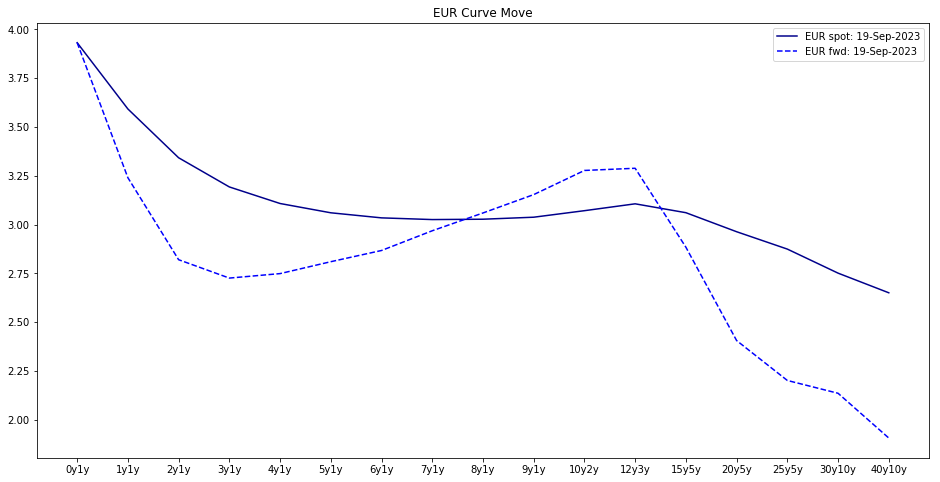

In [4]:
output1 = Output() 
    
CURVE_1_W = Dropdown(options = [i.upper() for i in forward_library.keys()], description  = 'Curve 1' )
ON_1_W = DatePicker(value = dt.today().date(), description = 'as of' )
UPTO_1_W = Dropdown(options = ['50y','30y','20y','15y','10y'], description = 'Max Tenor')
SPOT_1_W = Checkbox(value= True, description = 'Spot')
FWRD_1_W = Checkbox(value= False, description = 'Forward')

CURVE_2_W = Dropdown(options =['-']+ [i.upper() for i in forward_library.keys()], description  = 'Curve 2' )
ON_2_W = DatePicker(value = dt.today().date(), description = 'as of' )
UPTO_2_W = Dropdown(options = ['50y','30y','20y','15y','10y'], description = 'Max Tenor')
SPOT_2_W = Checkbox(value= False, description = 'Spot')
FWRD_2_W = Checkbox(value= False, description = 'Forward')

PLOT_B = Button(description = 'Plot')
C1= VBox([CURVE_1_W,ON_1_W, UPTO_1_W,SPOT_1_W,FWRD_1_W])
C2= VBox([CURVE_2_W,ON_2_W, UPTO_2_W,SPOT_2_W,FWRD_2_W])

display(HBox([C1,C2]))
display(PLOT_B, output1)

def plot_click(b):
    with output1:
        clear_output()
        fig, ax = plt.subplots(figsize = (16,8))
        
        if SPOT_1_W.value:
            spot_1 = produce_curve(CURVE_1_W.value.lower(), ON_1_W.value, int(UPTO_1_W.value[:-1]), kind = 'spot')
            d1 = spot_1.columns[0]
            ax.plot(spot_1[d1].values, color = 'darkblue', label = f"{CURVE_1_W.value} spot: {ON_1_W.value.strftime('%d-%b-%Y')}")
            ax.set_xticks(range(0,spot_1.shape[0]))
            ax.set_xticklabels(spot_1.index)
        
        if FWRD_1_W.value: 
            fwrd_1 = produce_curve(CURVE_1_W.value.lower(), ON_1_W.value, int(UPTO_1_W.value[:-1]), kind = 'fwrd')
            d1 = fwrd_1.columns[0]
            ax.plot(fwrd_1[d1].values, color = 'blue',linestyle = '--', label = f"{CURVE_1_W.value} fwd: {ON_1_W.value.strftime('%d-%b-%Y')}")
            ax.set_xticks(range(0,fwrd_1.shape[0]))
            ax.set_xticklabels(fwrd_1.index)
        
        if SPOT_2_W.value:
            spot_2 = produce_curve(CURVE_2_W.value.lower(), ON_2_W.value, int(UPTO_2_W.value[:-1]), kind = 'spot')
            d2 = spot_2.columns[0]
            ax.plot(spot_2[d2].values, color = 'darkred', label = f"{CURVE_2_W.value} spot: {ON_2_W.value.strftime('%d-%b-%Y')}")
        
        if FWRD_2_W.value: 
            fwrd_2 = produce_curve(CURVE_2_W.value.lower(), ON_2_W.value, int(UPTO_2_W.value[:-1]), kind = 'fwrd')
            d2 = fwrd_2.columns[0]
            ax.plot(fwrd_2[d2].values, color = 'red',linestyle = '--', label = f"{CURVE_2_W.value} fwd: {ON_2_W.value.strftime('%d-%b-%Y')}")
           
            
        ax.set_title(f"{CURVE_1_W.value} Curve Move")  
        ax.legend()
        plt.show()
        
        

PLOT_B.on_click(plot_click)

## EXPECTED EVOLUTION

In [5]:
IMP_TENORS = np.array([1,2,3,4,5,6,7,8,9,10,12,15,20,25,30])
FWD_CRV = [1,2,3,4,5,6,7,8,9,10,15,20]
all_c  = pd.DataFrame({},index = [f"{i}y" for i in IMP_TENORS] , columns=['spot']+['3m', '6m']+[f"{i}y" for i in FWD_CRV])
fill = False
ecy = None 

In [6]:
output2 = Output() 
    
CURVE_3_W = Dropdown(options = [i.upper() for i in forward_library.keys()], description  = 'Curve' )
ON_3_W = DatePicker(value = dt.today().date(), description = 'as of' )
CHART_B = Button(description = 'Chart Curve') 
LOAD_B = Button(description = 'Load Curve')

F_CHECKBOXES = {i:Checkbox(description = i.upper()) for i in all_c.columns}
CBOX_W = VBox([HBox([F_CHECKBOXES[k] for k in all_c.columns[:5]]),
         HBox([F_CHECKBOXES[k] for k in all_c.columns[5:10]]),
          HBox([F_CHECKBOXES[k] for k in all_c.columns[10:]])])

display(HBox([CURVE_3_W, ON_3_W]))
display(CBOX_W)
display(HBox([LOAD_B,CHART_B]), output2)


def load_click(b):
    global all_c, fill, ecy
    with output2:
        clear_output()
        on  = ON_3_W.value
        for f in all_c.columns:
            for t in all_c.index:
                if f == 'spot':
                    all_c.at[t,f] = swap_structure(CURVE_3_W.value.lower(),t,start=on, end = on, bps  = False).values[0][0]
                else:
                    all_c.at[t,f] = swap_structure(CURVE_3_W.value.lower(),f+t,start=on, end = on, bps  = False).values[0][0]
        fill = True
        ecy = CURVE_3_W.value
        print('Data loaded')


def chart_click(b):
    with output2:
        clear_output()
        if not fill:
            print('Load data before charting') 
        else:
            which = [i for i in F_CHECKBOXES.keys() if F_CHECKBOXES[i].value]
            all_c[which].plot(figsize = (15,8), use_index = True, title = ecy ,xticks = range(all_c.shape[0]))
            plt.show()
        
    


LOAD_B.on_click(load_click)
CHART_B.on_click(chart_click)

Output()